# Assignment 4

In [0]:

import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from os import listdir
from os.path import isfile, join
from PIL import Image

path = '/content/gdrive/My Drive/Colab Notebooks/input/JPEGImages'

imagesPaths = [f for f in listdir(path) if isfile(join(path, f))]

In [0]:
from matplotlib.pyplot import imshow

X = []
Y_mid = []
Y_large = []

for imagePath in imagesPaths[:50]:
    image = Image.open(join(path,imagePath),'r')
    X.append(np.asarray(image.resize((72,72), Image.ANTIALIAS)))
    Y_mid.append(np.asarray(image.resize((144,144), Image.ANTIALIAS)))
    Y_large.append(np.asarray(image.resize((288,288), Image.ANTIALIAS)))

In [0]:
X = np.asarray(X)
Y_mid = np.asarray(Y_mid)
Y_large = np.asarray(Y_large)

In [0]:
print(X.shape)
print(Y_mid.shape)
print(Y_large.shape)


(50, 72, 72, 3)
(50, 144, 144, 3)
(50, 288, 288, 3)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X, test_size=0.2)
Y_mid_train, Y_mid_val = train_test_split(Y_mid, test_size=0.2)

In [0]:
print(X_train.shape)
print(X_val.shape)
print(Y_mid_train.shape)
print(Y_mid_val.shape)

(40, 72, 72, 3)
(10, 72, 72, 3)
(40, 144, 144, 3)
(10, 144, 144, 3)


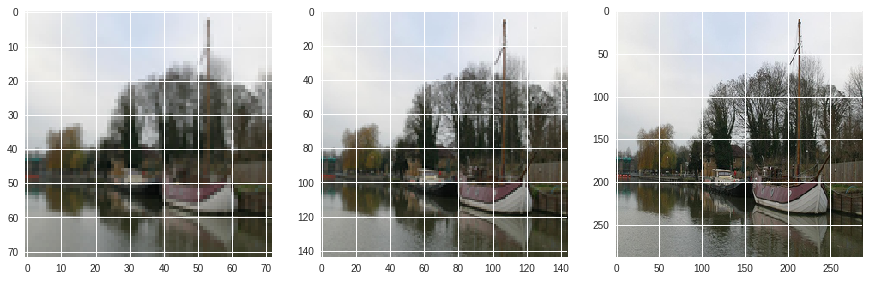

In [0]:
fig=plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
plt.imshow(X[1])
fig.add_subplot(1, 3, 2)
plt.imshow(Y_mid[1])
fig.add_subplot(1, 3, 3)
plt.imshow(Y_large[1])
plt.show()

In [0]:
from keras.models import Model,Sequential
from keras.layers import * # Dense, Embedding, LSTM
from keras.applications import VGG16

Using TensorFlow backend.


## Resnet block

In [0]:
def resnetBlock():
    inp = Input(shape=(None,None,64))
    x= Conv2D(filters = 64, kernel_size = 3, padding = 'same')(inp)
    x= Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
    out = Add()([inp,x])
    out = Activation('relu')(out)
    return Model(output = out,input = inp)

In [0]:
resnetBlock()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


## Initial Model

In [0]:
inp = Input(shape=(None,None,3))
model = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(inp)
model = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model)
model = UpSampling2D()(model)
out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model)
model = Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='mse')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, None, None, 64)    256       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, None, None, 64)    4160      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, None, None, 3)     195       
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train,Y_mid_train,epochs = 10,batch_size = 1)

Epoch 1/10
40/40 [==============================] - 1s 32ms/step - loss: 9615.7475
Epoch 2/10
40/40 [==============================] - 1s 24ms/step - loss: 8326.0619
Epoch 3/10
40/40 [==============================] - 1s 24ms/step - loss: 8413.6598
Epoch 4/10
40/40 [==============================] - 1s 24ms/step - loss: 8302.9748
Epoch 5/10
40/40 [==============================] - 1s 24ms/step - loss: 8386.3638
Epoch 6/10
40/40 [==============================] - 1s 24ms/step - loss: 8323.6010
Epoch 7/10
40/40 [==============================] - 1s 23ms/step - loss: 8393.5839
Epoch 8/10
40/40 [==============================] - 1s 24ms/step - loss: 8325.4561
Epoch 9/10
40/40 [==============================] - 1s 23ms/step - loss: 8303.8044
Epoch 10/10
40/40 [==============================] - 1s 24ms/step - loss: 8317.5935


## Adding a second output and Resnet Block:

In [70]:
inp = Input(shape=(None,None,3))
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(inp)
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(model2)
model2 = UpSampling2D()(model2)
mid_out = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(mid_out)
model2 = UpSampling2D()(model2)
large_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model2)

model2 = Model(inputs=inp,outputs=[mid_out,large_out])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


## Adding VGG16 Features:

Lets take use the 'block1_conv2' as the feature extractor for our model.  We will concatenate the features with the original input.

In [68]:
vgg = VGG16(weights='imagenet', include_top = False)
vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block1_conv2').output)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [62]:
vgg.predict()


'block1_conv2/Relu:0'

In [66]:
inp = Input(shape=(None,None,3))
vgg_layer = vgg_fe(inp)
model2 = concatenate([inp,vgg_fe])
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(model2)
model2 = UpSampling2D()(model2)
mid_out = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(mid_out)
model2 = UpSampling2D()(model2)
large_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model2)

model2 = Model(inputs=inp,outputs=[mid_out,large_out])
model.compile(optimizer='adam', loss='mse')

TypeError: ignored

In [0]:
import keras.backend as K
K.depth_to_space
